In [14]:
from pyspark.sql.functions import udf
df = spark.read.load('hdfs://orion11:11001/Project3/part-0*'
                     , format='csv', sep='\t'
                     , inferSchema='true'
                      , header='true')

In [15]:
import pygeohash as pgh
import pyspark.sql.functions as F
geohashEncodeUDF = F.udf(lambda x, y: pgh.encode(x, y))

df = df.withColumnRenamed('1_time', 'time').withColumnRenamed('2_lat', 'lat').withColumnRenamed('3_lon', 'lon').withColumnRenamed('_c18', 'geohash')
df = df.withColumn('geohash', geohashEncodeUDF(df['lat'], df['lon']))
df.take(3)

[Row(time=1455440400000, lat=28.862712472612284, lon=-80.15570444411433, albedo_surface='6.0', precipitable_water_entire_atmosphere_single_layer='null', pressure_maximum_wind='17126.896', pressure_surface='102390.0', pressure_tropopause='23103.373', relative_humidity_zerodegc_isotherm='35.0', snow_depth_surface='0.0', temperature_surface='295.9439', temperature_tropopause='219.42467', total_cloud_cover_entire_atmosphere_single_layer='null', total_precipitation_surface_3_hour_accumulation='0.0', vegetation_surface='0.0', visibility_surface='24223.668', wilting_point_surface='0.0', wind_speed_gust_surface='null', geohash='djph0n23kxwf'),
 Row(time=1455440400000, lat=57.697196193266976, lon=-79.3345809744617, albedo_surface='65.0', precipitable_water_entire_atmosphere_single_layer='null', pressure_maximum_wind='11126.896', pressure_surface='101925.0', pressure_tropopause='30303.373', relative_humidity_zerodegc_isotherm='76.0', snow_depth_surface='0.049999997', temperature_surface='243.693

In [60]:
from pyspark.sql.functions import col
# Remove rows with 'null' string value in any column
df_cleaned = df.filter(~col("precipitable_water_entire_atmosphere_single_layer").isin('null'))
# Remove rows with 'null' string value in any column
df_cleaned = df_cleaned.filter(~col("temperature_surface").isin('null'))

In [16]:
df.createOrReplaceTempView("df_temp")

In [67]:
# Climate Change: Using two-character geohash aggregates across the entire NAM grid, determine temperature trends over 
# the past 5 years. With the regions that have experienced an increase in temperatures, build a correlation matrix 
# using Pearson’s correlation coefficient (PCC) to determine how the variables influence one another. Finally, determine
# whether or not the correlations are different based on the region (e.g., maybe temperature has increased in lockstep 
# with humidity in one location but not another). Analyze your results: can you draw any conclusions from what you’ve 
# found?
import math
from pyspark.mllib.stat import Statistics

feats = []
with open('features.txt') as f:
    feats = [line.strip() for line in f.readlines()[2:]]

df = spark.sql("""
    SELECT 
    albedo_surface, 
    precipitable_water_entire_atmosphere_single_layer, 
    pressure_maximum_wind,
    pressure_surface, 
    pressure_tropopause, 
    relative_humidity_zerodegc_isotherm,
    snow_depth_surface, 
    temperature_surface, 
    temperature_tropopause,
    total_cloud_cover_entire_atmosphere_single_layer, 
    total_precipitation_surface_3_hour_accumulation,
    vegetation_surface, 
    visibility_surface, 
    wilting_point_surface, 
    wind_speed_gust_surface
    FROM df_temp
    WHERE geohash LIKE '9x%' and wind_speed_gust_surface != 'null' and precipitable_water_entire_atmosphere_single_layer != 'null'
    and total_cloud_cover_entire_atmosphere_single_layer != 'null' and temperature_surface != 'null'
""")

# Convert DataFrame to RDD of tuples
features = df.rdd.map(lambda row: tuple(row))
col_names = df.columns
scores_array = []
corr_mat = Statistics.corr(features, method="pearson")

for i in range(0, 13):
    for j in range(0, 13):
        print(corr_mat[i, j])
        scores_array.append((corr_mat[i, j], feats[i], feats[j]))

for y in range(0, len(scores_array)):
    if math.isnan(scores_array[y][0]):
        scores_array[y] = (0, scores_array[y][1], scores_array[y][2])

# sorting in reverse
scores_array.sort(reverse=True, key=lambda x: abs(x[0]))
print(scores_array)

23/05/22 04:02:18 WARN TaskSetManager: Lost task 1.0 in stage 76.0 (TID 6477) (10.0.1.29 executor 21): org.apache.spark.sql.execution.QueryExecutionException: Encountered error while reading file hdfs://orion11:11001/Project3/part-00030-300232b0-d488-4017-8741-efda0762a4d3-c000.tdv.gz. Details: 
	at org.apache.spark.sql.errors.QueryExecutionErrors$.cannotReadFilesError(QueryExecutionErrors.scala:731)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:283)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:116)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at sca

23/05/22 04:02:26 WARN TaskSetManager: Lost task 16.0 in stage 77.0 (TID 6513) (10.0.1.22 executor 20): java.io.IOException: incorrect header check
	at org.apache.hadoop.io.compress.zlib.ZlibDecompressor.inflateBytesDirect(Native Method)
	at org.apache.hadoop.io.compress.zlib.ZlibDecompressor.decompress(ZlibDecompressor.java:225)
	at org.apache.hadoop.io.compress.DecompressorStream.decompress(DecompressorStream.java:111)
	at org.apache.hadoop.io.compress.DecompressorStream.read(DecompressorStream.java:105)
	at java.base/java.io.InputStream.read(InputStream.java:205)
	at org.apache.hadoop.util.LineReader.fillBuffer(LineReader.java:191)
	at org.apache.hadoop.util.LineReader.readDefaultLine(LineReader.java:227)
	at org.apache.hadoop.util.LineReader.readLine(LineReader.java:185)
	at org.apache.hadoop.mapreduce.lib.input.LineRecordReader.skipUtfByteOrderMark(LineRecordReader.java:158)
	at org.apache.hadoop.mapreduce.lib.input.LineRecordReader.nextKeyValue(LineRecordReader.java:198)
	at org.

1.0
-0.32876037279202674
0.09299648062050242
-0.06331018563061122
0.3312033526046111
0.3006229306878314
0.6753268242721471
-0.4755451378532127
0.12583315702655154
0.12086842825139503
0.034331141735920535
-0.4267477826478016
-0.2178706092637409
-0.32876037279202674
1.0
-0.11909568602952875
0.36200632337062716
-0.5020376784371261
-0.0014540612997474694
-0.350961547761044
0.6735140271750317
-0.2741576276988989
0.06321237683956434
0.10439125607078491
0.4316703744634368
0.07661478387815497
0.09299648062050242
-0.11909568602952875
1.0
0.006777504004157043
0.2153222401224591
0.16975822987134329
0.08709698251812974
-0.1462826215517284
0.24788545577616988
0.11625903713403446
0.026746802442033174
-0.08290270347322395
-0.08881825920865322
-0.06331018563061122
0.36200632337062716
0.006777504004157043
1.0
0.003639619876053058
-0.1164933176576662
-0.2888605873040968
0.17371136029774578
0.023391035076909903
-0.07036735416628287
-0.07396206189818443
-0.08477744442787437
0.1489064797441997
0.3312033526

[]

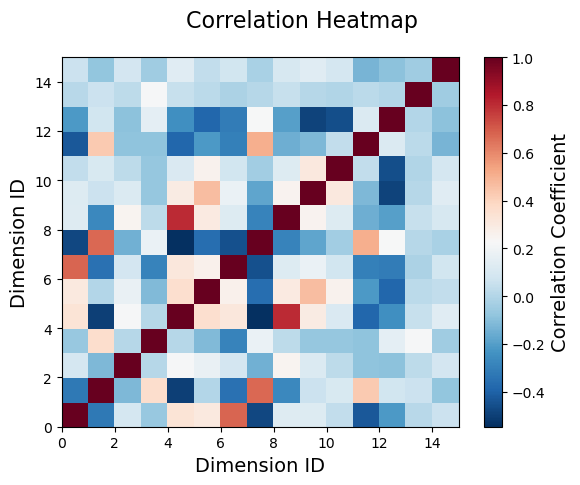

In [68]:
import sys
import numpy as np
import matplotlib.pyplot as plt

plt.suptitle('Correlation Heatmap', fontsize=16)
plt.xlabel('Dimension ID', fontsize=14)
plt.ylabel('Dimension ID', fontsize=14)

plt.pcolor(corr_mat, cmap='RdBu_r')
cb = plt.colorbar()
cb.set_label('Correlation Coefficient', fontsize=14)
plt.plot()

In [69]:
# snow_depth_surface and albedo are strongly co-related.
# precipitable_water_entire_atmosphere_single_layer and temperature_surface are strongly co-related.
# pressure_tropopause and temperature_tropopause are strongly co-related.
temp_surface = spark.sql("""
                        Select YEAR(FROM_UNIXTIME(time/1000)),
                         AVG(CASE WHEN temperature_surface == 'null' THEN 0.0 ELSE temperature_surface END),
                        AVG(CASE WHEN precipitable_water_entire_atmosphere_single_layer == 'null' THEN 0.0 ELSE precipitable_water_entire_atmosphere_single_layer END)
                        from df_temp 
                         where geohash LIKE '9x%' 
                         GROUP BY YEAR(FROM_UNIXTIME(time/1000)) """).collect()
# print(temp_surface)
# temp_surface.show(3)

In [70]:
print(temp_surface[:5])

[Row(year(from_unixtime((time / 1000), yyyy-MM-dd HH:mm:ss))=2015, avg(CASE WHEN (temperature_surface = null) THEN 0.0 ELSE temperature_surface END)=282.1496568564598, avg(CASE WHEN (precipitable_water_entire_atmosphere_single_layer = null) THEN 0.0 ELSE precipitable_water_entire_atmosphere_single_layer END)=0.0), Row(year(from_unixtime((time / 1000), yyyy-MM-dd HH:mm:ss))=2016, avg(CASE WHEN (temperature_surface = null) THEN 0.0 ELSE temperature_surface END)=280.3302151301624, avg(CASE WHEN (precipitable_water_entire_atmosphere_single_layer = null) THEN 0.0 ELSE precipitable_water_entire_atmosphere_single_layer END)=0.0), Row(year(from_unixtime((time / 1000), yyyy-MM-dd HH:mm:ss))=2018, avg(CASE WHEN (temperature_surface = null) THEN 0.0 ELSE temperature_surface END)=280.6623647452187, avg(CASE WHEN (precipitable_water_entire_atmosphere_single_layer = null) THEN 0.0 ELSE precipitable_water_entire_atmosphere_single_layer END)=10.883690347968521), Row(year(from_unixtime((time / 1000), y

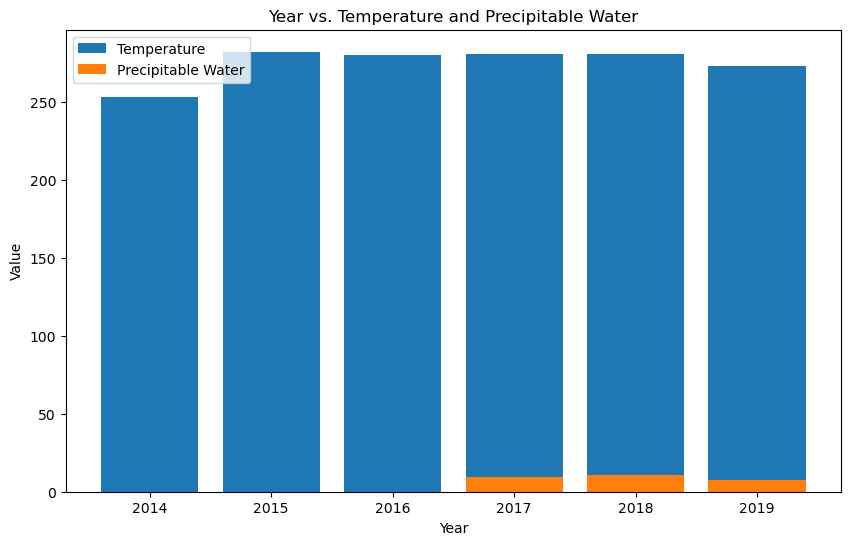

In [71]:
import matplotlib.pyplot as plt


years = [row[0] for row in temp_surface]
temperature = [row[1] for row in temp_surface]
precipitable_water = [row[2] for row in temp_surface]

plt.figure(figsize=(10, 6))

plt.bar(years, temperature, label='Temperature')
plt.bar(years, precipitable_water, label='Precipitable Water')

plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Year vs. Temperature and Precipitable Water')

plt.legend()
plt.show()


In [ ]:
# In 2017 2018 2019, we can observe increase in precipitable water and ultimately increase in temperature.

In [72]:
# snow_depth_surface and albedo are strongly co-related.
# precipitable_water_entire_atmosphere_single_layer and temperature_surface are strongly co-related.
# pressure_tropopause and temperature_tropopause are strongly co-related.
temp_surface = spark.sql("""
                        Select YEAR(FROM_UNIXTIME(time/1000)),
                         AVG(CASE WHEN temperature_surface == 'null' THEN 0.0 ELSE temperature_surface END),
                        AVG(CASE WHEN precipitable_water_entire_atmosphere_single_layer == 'null' THEN 0.0 ELSE precipitable_water_entire_atmosphere_single_layer END)
                        from df_temp 
                         where geohash LIKE '9r%' 
                         GROUP BY YEAR(FROM_UNIXTIME(time/1000)) """).collect()
# print(temp_surface)
# temp_surface.show(3)

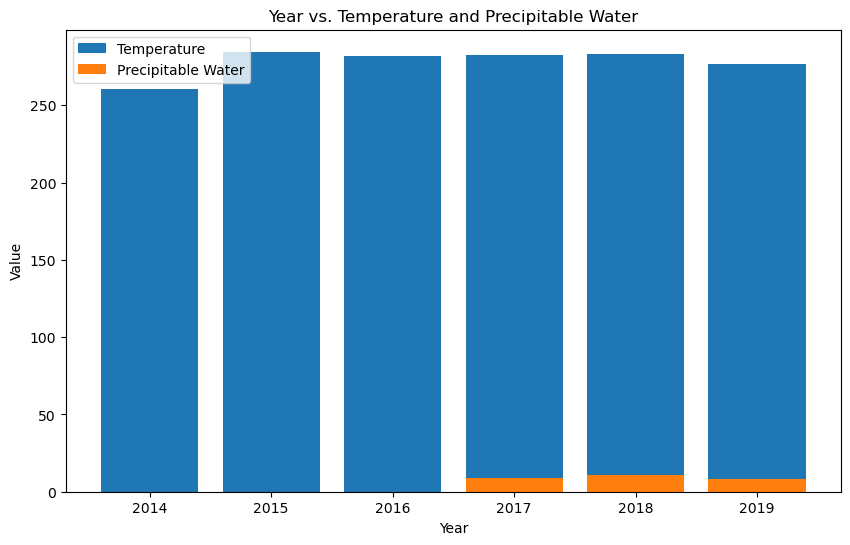

In [73]:
import matplotlib.pyplot as plt


years = [row[0] for row in temp_surface]
temperature = [row[1] for row in temp_surface]
precipitable_water = [row[2] for row in temp_surface]

plt.figure(figsize=(10, 6))

plt.bar(years, temperature, label='Temperature')
plt.bar(years, precipitable_water, label='Precipitable Water')

plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Year vs. Temperature and Precipitable Water')

plt.legend()
plt.show()

In [ ]:
# Co-relation are not region based because we see similar trend for wyoming and oregon.